In [23]:
from __future__ import print_function
import models
import os
import torch
from torch import optim, nn
from torchvision import transforms, datasets
import torchvision
import common
import numpy as np
import loguru
import tqdm 
import time
import matplotlib.pyplot as plt

Log=loguru.logger


#############################  Model save path

os.chdir("..")                                                              
SAVE_DIR = '/home/minnib/HPC/models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'base_2.pt')


############################ HYPERPARAMETERS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS=400
BATCH_SIZE =64                                                           # batch_size 64,128,256
criterion = nn.CrossEntropyLoss()
ADAM_OPTIMISER=True
LEARNING_RATE=0.0001


############################ Image process

train_transforms = transforms.Compose([# Data Transforms
                           transforms.Resize(256),#Resize
                           transforms.RandomHorizontalFlip(30),#Flip
                           transforms.RandomRotation(10),#Roatate
                           transforms.RandomCrop(256),#Crop
                           transforms.ToTensor(),#Convert to Tensor
                           transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#Normalize
                       ])

test_transforms = transforms.Compose([transforms.Resize(256),
                           transforms.ToTensor(),
                           transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
                       ])

######################### down load dataset

train_data = torchvision.datasets.CIFAR10(root='/home/minnib/HPC/dataset/', train=False, download=False, transform=train_transforms)#Use CIFAR10 to train
train_data, valid_data = torch.utils.data.random_split(train_data, [int(len(train_data)*0.9), len(train_data) - int(len(train_data)*0.9)])
test_data = torchvision.datasets.CIFAR10(root='/home/minnib/HPC/dataset/', train=False, download=False, transform=test_transforms)

print('Number of training examples:{:d}'.format(len(train_data)))
print('Number of valid examples:{:d}'.format(len(valid_data)))
print('Number of test examples:{:d}'.format(len(test_data)))

train_iterator = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

Log.info('Finishing data preprocess...')


########################### model
Log.info('Loading model...')
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 10)

if torch.cuda.device_count() > 1:                           
    print("Use", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)
    model = model.to(device)
else:
    model = model.to(device)

    
############################## Hyperparameters:

if(ADAM_OPTIMISER):
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
else:
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.5)

###############################Train model:
Train_loss=[]
Valid_loss=[]
Train_acc=[]
Valid_acc=[]

best_valid_loss = float('inf')

Log.info('Starting training')
for epoch in range(EPOCHS):
    train_loss, train_acc = common.train(model, device, train_iterator, optimizer, criterion)    #Train Loss
    valid_loss, valid_acc = common.evaluate(model, device, valid_iterator, criterion)            #Validation Loss
    
    Train_loss.append(train_loss)
    Train_acc.append(train_acc)
    Valid_loss.append(valid_loss)
    Valid_acc.append(valid_acc)
    
    if valid_loss < best_valid_loss:                        #Validation Loss - Is current lower than the saved validation loss.
        best_valid_loss = valid_loss                        #Save the best loss (lowest)
        torch.save(model.state_dict(), MODEL_SAVE_PATH)     #Save the model

    Log.info('| Epoch: {:d} | Train Loss: {:.3f} | Train Acc: {:.3f} | Val. Loss: {:.3f} | Val. Acc: {:.3f} |'.format(epoch+1,train_loss,train_acc,valid_loss, valid_acc))

Log.info('Complete training process good luck!!')


2020-09-14 20:10:22.806 | INFO     | __main__:<module>:65 - Finishing data preprocess...
2020-09-14 20:10:22.807 | INFO     | __main__:<module>:69 - Loading model...


Number of training examples:9000
Number of valid examples:1000
Number of test examples:10000


2020-09-14 20:10:23.016 | INFO     | __main__:<module>:104 - Starting training
2020-09-14 20:10:41.664 | INFO     | __main__:<module>:118 - | Epoch: 1 | Train Loss: 2.209 | Train Acc: 0.198 | Val. Loss: 2.034 | Val. Acc: 0.340 |
2020-09-14 20:11:00.135 | INFO     | __main__:<module>:118 - | Epoch: 2 | Train Loss: 1.913 | Train Acc: 0.404 | Val. Loss: 1.769 | Val. Acc: 0.498 |
2020-09-14 20:11:18.636 | INFO     | __main__:<module>:118 - | Epoch: 3 | Train Loss: 1.705 | Train Acc: 0.516 | Val. Loss: 1.584 | Val. Acc: 0.583 |
2020-09-14 20:11:37.144 | INFO     | __main__:<module>:118 - | Epoch: 4 | Train Loss: 1.551 | Train Acc: 0.568 | Val. Loss: 1.454 | Val. Acc: 0.596 |
2020-09-14 20:11:55.523 | INFO     | __main__:<module>:118 - | Epoch: 5 | Train Loss: 1.431 | Train Acc: 0.606 | Val. Loss: 1.345 | Val. Acc: 0.666 |
2020-09-14 20:12:14.207 | INFO     | __main__:<module>:118 - | Epoch: 6 | Train Loss: 1.343 | Train Acc: 0.630 | Val. Loss: 1.251 | Val. Acc: 0.675 |
2020-09-14 20:12:33.5

2020-09-14 20:27:18.776 | INFO     | __main__:<module>:118 - | Epoch: 55 | Train Loss: 0.743 | Train Acc: 0.753 | Val. Loss: 0.731 | Val. Acc: 0.760 |
2020-09-14 20:27:37.118 | INFO     | __main__:<module>:118 - | Epoch: 56 | Train Loss: 0.748 | Train Acc: 0.753 | Val. Loss: 0.711 | Val. Acc: 0.769 |
2020-09-14 20:27:55.508 | INFO     | __main__:<module>:118 - | Epoch: 57 | Train Loss: 0.753 | Train Acc: 0.749 | Val. Loss: 0.713 | Val. Acc: 0.755 |
2020-09-14 20:28:13.902 | INFO     | __main__:<module>:118 - | Epoch: 58 | Train Loss: 0.746 | Train Acc: 0.753 | Val. Loss: 0.671 | Val. Acc: 0.791 |
2020-09-14 20:28:32.228 | INFO     | __main__:<module>:118 - | Epoch: 59 | Train Loss: 0.751 | Train Acc: 0.753 | Val. Loss: 0.706 | Val. Acc: 0.753 |
2020-09-14 20:28:50.562 | INFO     | __main__:<module>:118 - | Epoch: 60 | Train Loss: 0.747 | Train Acc: 0.752 | Val. Loss: 0.714 | Val. Acc: 0.764 |
2020-09-14 20:29:08.860 | INFO     | __main__:<module>:118 - | Epoch: 61 | Train Loss: 0.739 |

2020-09-14 20:44:06.745 | INFO     | __main__:<module>:118 - | Epoch: 110 | Train Loss: 0.687 | Train Acc: 0.766 | Val. Loss: 0.660 | Val. Acc: 0.765 |
2020-09-14 20:44:25.121 | INFO     | __main__:<module>:118 - | Epoch: 111 | Train Loss: 0.689 | Train Acc: 0.770 | Val. Loss: 0.627 | Val. Acc: 0.791 |
2020-09-14 20:44:43.406 | INFO     | __main__:<module>:118 - | Epoch: 112 | Train Loss: 0.683 | Train Acc: 0.766 | Val. Loss: 0.650 | Val. Acc: 0.782 |
2020-09-14 20:45:01.683 | INFO     | __main__:<module>:118 - | Epoch: 113 | Train Loss: 0.686 | Train Acc: 0.765 | Val. Loss: 0.645 | Val. Acc: 0.773 |
2020-09-14 20:45:19.965 | INFO     | __main__:<module>:118 - | Epoch: 114 | Train Loss: 0.681 | Train Acc: 0.768 | Val. Loss: 0.666 | Val. Acc: 0.772 |
2020-09-14 20:45:38.255 | INFO     | __main__:<module>:118 - | Epoch: 115 | Train Loss: 0.690 | Train Acc: 0.768 | Val. Loss: 0.638 | Val. Acc: 0.779 |
2020-09-14 20:45:56.514 | INFO     | __main__:<module>:118 - | Epoch: 116 | Train Loss: 

2020-09-14 21:00:33.497 | INFO     | __main__:<module>:118 - | Epoch: 164 | Train Loss: 0.661 | Train Acc: 0.772 | Val. Loss: 0.661 | Val. Acc: 0.773 |
2020-09-14 21:00:51.685 | INFO     | __main__:<module>:118 - | Epoch: 165 | Train Loss: 0.651 | Train Acc: 0.780 | Val. Loss: 0.638 | Val. Acc: 0.774 |
2020-09-14 21:01:09.877 | INFO     | __main__:<module>:118 - | Epoch: 166 | Train Loss: 0.653 | Train Acc: 0.778 | Val. Loss: 0.654 | Val. Acc: 0.775 |
2020-09-14 21:01:28.058 | INFO     | __main__:<module>:118 - | Epoch: 167 | Train Loss: 0.659 | Train Acc: 0.776 | Val. Loss: 0.623 | Val. Acc: 0.778 |
2020-09-14 21:01:46.239 | INFO     | __main__:<module>:118 - | Epoch: 168 | Train Loss: 0.656 | Train Acc: 0.770 | Val. Loss: 0.618 | Val. Acc: 0.791 |
2020-09-14 21:02:04.425 | INFO     | __main__:<module>:118 - | Epoch: 169 | Train Loss: 0.660 | Train Acc: 0.772 | Val. Loss: 0.658 | Val. Acc: 0.772 |
2020-09-14 21:02:22.627 | INFO     | __main__:<module>:118 - | Epoch: 170 | Train Loss: 

2020-09-14 21:17:03.108 | INFO     | __main__:<module>:118 - | Epoch: 218 | Train Loss: 0.642 | Train Acc: 0.781 | Val. Loss: 0.631 | Val. Acc: 0.777 |
2020-09-14 21:17:21.447 | INFO     | __main__:<module>:118 - | Epoch: 219 | Train Loss: 0.631 | Train Acc: 0.784 | Val. Loss: 0.608 | Val. Acc: 0.783 |
2020-09-14 21:17:39.781 | INFO     | __main__:<module>:118 - | Epoch: 220 | Train Loss: 0.631 | Train Acc: 0.784 | Val. Loss: 0.620 | Val. Acc: 0.774 |
2020-09-14 21:17:58.117 | INFO     | __main__:<module>:118 - | Epoch: 221 | Train Loss: 0.641 | Train Acc: 0.779 | Val. Loss: 0.602 | Val. Acc: 0.780 |
2020-09-14 21:18:16.458 | INFO     | __main__:<module>:118 - | Epoch: 222 | Train Loss: 0.647 | Train Acc: 0.779 | Val. Loss: 0.609 | Val. Acc: 0.773 |
2020-09-14 21:18:34.786 | INFO     | __main__:<module>:118 - | Epoch: 223 | Train Loss: 0.640 | Train Acc: 0.783 | Val. Loss: 0.606 | Val. Acc: 0.784 |
2020-09-14 21:18:53.103 | INFO     | __main__:<module>:118 - | Epoch: 224 | Train Loss: 

2020-09-14 21:33:32.214 | INFO     | __main__:<module>:118 - | Epoch: 272 | Train Loss: 0.625 | Train Acc: 0.783 | Val. Loss: 0.622 | Val. Acc: 0.786 |
2020-09-14 21:33:50.359 | INFO     | __main__:<module>:118 - | Epoch: 273 | Train Loss: 0.634 | Train Acc: 0.781 | Val. Loss: 0.623 | Val. Acc: 0.787 |
2020-09-14 21:34:08.538 | INFO     | __main__:<module>:118 - | Epoch: 274 | Train Loss: 0.620 | Train Acc: 0.788 | Val. Loss: 0.637 | Val. Acc: 0.772 |
2020-09-14 21:34:26.729 | INFO     | __main__:<module>:118 - | Epoch: 275 | Train Loss: 0.630 | Train Acc: 0.784 | Val. Loss: 0.616 | Val. Acc: 0.779 |
2020-09-14 21:34:44.930 | INFO     | __main__:<module>:118 - | Epoch: 276 | Train Loss: 0.630 | Train Acc: 0.785 | Val. Loss: 0.590 | Val. Acc: 0.793 |
2020-09-14 21:35:03.121 | INFO     | __main__:<module>:118 - | Epoch: 277 | Train Loss: 0.634 | Train Acc: 0.785 | Val. Loss: 0.620 | Val. Acc: 0.775 |
2020-09-14 21:35:21.308 | INFO     | __main__:<module>:118 - | Epoch: 278 | Train Loss: 

2020-09-14 21:49:57.366 | INFO     | __main__:<module>:118 - | Epoch: 326 | Train Loss: 0.609 | Train Acc: 0.794 | Val. Loss: 0.603 | Val. Acc: 0.792 |
2020-09-14 21:50:15.618 | INFO     | __main__:<module>:118 - | Epoch: 327 | Train Loss: 0.619 | Train Acc: 0.787 | Val. Loss: 0.647 | Val. Acc: 0.761 |
2020-09-14 21:50:33.867 | INFO     | __main__:<module>:118 - | Epoch: 328 | Train Loss: 0.625 | Train Acc: 0.780 | Val. Loss: 0.612 | Val. Acc: 0.781 |
2020-09-14 21:50:52.123 | INFO     | __main__:<module>:118 - | Epoch: 329 | Train Loss: 0.617 | Train Acc: 0.787 | Val. Loss: 0.613 | Val. Acc: 0.795 |
2020-09-14 21:51:10.370 | INFO     | __main__:<module>:118 - | Epoch: 330 | Train Loss: 0.618 | Train Acc: 0.787 | Val. Loss: 0.601 | Val. Acc: 0.789 |
2020-09-14 21:51:28.613 | INFO     | __main__:<module>:118 - | Epoch: 331 | Train Loss: 0.619 | Train Acc: 0.791 | Val. Loss: 0.590 | Val. Acc: 0.796 |
2020-09-14 21:51:46.863 | INFO     | __main__:<module>:118 - | Epoch: 332 | Train Loss: 

2020-09-14 22:06:22.874 | INFO     | __main__:<module>:118 - | Epoch: 380 | Train Loss: 0.603 | Train Acc: 0.790 | Val. Loss: 0.609 | Val. Acc: 0.796 |
2020-09-14 22:06:41.132 | INFO     | __main__:<module>:118 - | Epoch: 381 | Train Loss: 0.615 | Train Acc: 0.787 | Val. Loss: 0.609 | Val. Acc: 0.787 |
2020-09-14 22:06:59.390 | INFO     | __main__:<module>:118 - | Epoch: 382 | Train Loss: 0.606 | Train Acc: 0.796 | Val. Loss: 0.599 | Val. Acc: 0.798 |
2020-09-14 22:07:17.626 | INFO     | __main__:<module>:118 - | Epoch: 383 | Train Loss: 0.615 | Train Acc: 0.784 | Val. Loss: 0.606 | Val. Acc: 0.781 |
2020-09-14 22:07:35.864 | INFO     | __main__:<module>:118 - | Epoch: 384 | Train Loss: 0.609 | Train Acc: 0.790 | Val. Loss: 0.615 | Val. Acc: 0.790 |
2020-09-14 22:07:54.107 | INFO     | __main__:<module>:118 - | Epoch: 385 | Train Loss: 0.616 | Train Acc: 0.783 | Val. Loss: 0.636 | Val. Acc: 0.774 |
2020-09-14 22:08:12.624 | INFO     | __main__:<module>:118 - | Epoch: 386 | Train Loss: 

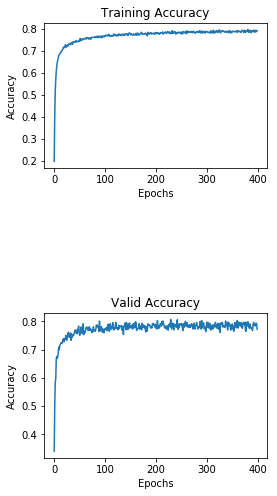

In [24]:
# plot the training result

fig = plt.figure(figsize=(4,8))
fig.tight_layout()
plt.subplots_adjust(wspace =0, hspace =1)
ax1 = fig.add_subplot(211)
ax1.plot(Train_acc)
ax1.set(xlabel='Epochs', ylabel='Accuracy',title='Training Accuracy')

ax2 = fig.add_subplot(212)
ax2.plot(Valid_acc)
ax2.set(xlabel='Epochs', ylabel='Accuracy',title='Valid Accuracy')
plt.show()
 

The Inference is dog


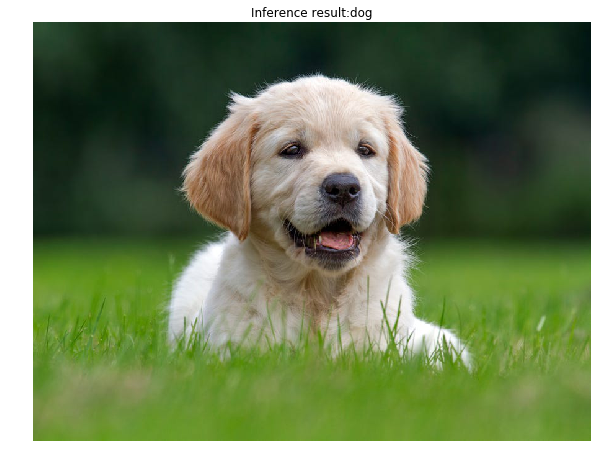

In [22]:
# infenrence

from PIL import Image

image_path = "/home/minnib/HPC/Homework_1_sample_code/dog.jpg"

def Infenrence(transforms,image_path):
    
    image = Image.open(image_path)

    image =transforms(image).float()
    
    return image


image_tensor=Infenrence(test_transforms,image_path)

image_tensor=image_tensor.unsqueeze(0)


# load model
model = torchvision.models.resnet18(pretrained=False)
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 10)

model.eval()

model.load_state_dict(torch.load(MODEL_SAVE_PATH))                                     

output=model(image_tensor)

_,prediction = torch.max(output.data,1)

print("The Inference is {:s}".format(label[prediction.numpy()[0]]))

label = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

fig=plt.figure(figsize=(10,10))

plt.imshow(np.array(Image.open(image_path)))

plt.title('Inference result:{:s}'.format(label[prediction.numpy()[0]]))

plt.savefig('/home/minnib/HPC/Homework_1_sample_code/test_result.png', format='png')

plt.axis('off')

plt.show()
